# Session 2 - Machine Learning (ML) Exploratory Data Analysis

This is an introductory notebook to familiarize yourself with Exploratory Data Analysis techniques for Machine Learning (ML). For this work, we will use data from the Moderate Resolution Imaging Spectroradiometer (MODIS) instrument to test several data science techniques and machine learning algorithms.

The intent of this notebook is three-fold. First an Exploratory Data Analysis (EDA) is conducted to visualise the optical data of the MODIS instrument and the distribution of this tabular dataset across water pixels. Next, this notebook briefly reviews the correlation of some of these spectral bands in the task of water classification. Finally, we introduce the topic of feature engineering and outlier detection that might be of use for other applications. The entire work is done using the Python programming language and based on a dataset uploaded to [Hugging Face](https://huggingface.co/datasets/nasa-cisto-data-science-group/modis-lake-powell-toy-dataset).

**Author**: Caleb S. Spradlin, Jordan A. Caraballo-Vega  
**Release Date**: 2023.04.08  
**Last Modified**: 2023.04.08  

## 1. Import Libraries

In this section we import the Python libraries to use during the development of this notebook. The default Python kernel from Google Colab does not include all fo the packages we need, thus we proceed to install them via pip.

In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 778.5 kB/s eta 0:00:00


In [41]:
import os
import sys
import csv
import glob
import joblib
import datasets
import numpy as np
import pandas as pd
from pathlib import Path

# Machine Learning imports
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier as cumlRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, KFold
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Geospatial related imports
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

# Ignore a few warnings for cleaner output
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Define General Variables

In this section we define general variables to work with through this notebook. A description of each variable is listed below as a comment next to the variable definition.

In [4]:
# url of the dataset we will be using, this is a link to the Hugging Face repository
# of this tutorial
DATASET_URL = 'nasa-cisto-data-science-group/modis-lake-powell-toy-dataset'

# controls random seed for reproducibility
RANDOM_STATE = 42

# column name for label, in our case this will be a categorical value
LABEL_NAME = 'water'

# data type of the label, you would change this to something else if your
# problem was for example a regression problem of type np.float32
DATA_TYPE = np.int16

# columns not needed for training
colsToDrop = ['x_offset', 'y_offset', 'year', 'julian_day']

# columns used as features during training
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

Here we create an output directory to store any artifacts out of our EDA visualizations.

In [17]:
os.makedirs('output', exist_ok=True)

## 3. Data Loading

In this section we will go ahead and load our data to analyze. We have extracted a tabular dataset from MODIS GeoTIFF files for the purpose of performing EDA. Here we will:
  - Read in data to a Dataframe
  - Drop unnecessary columns
  - Split into Xs and Ys

In [18]:
%%time
dataset = datasets.load_dataset(DATASET_URL, split='train')
df_pandas = pd.DataFrame(dataset)
df_pandas.head()

CPU times: user 192 ms, sys: 5.65 ms, total: 198 ms
Wall time: 356 ms


,water,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
0,0,2031,3113,776,1200,3626,3480,2957,2103,-556,257
1,1,410,494,183,319,295,329,307,929,2004,2334
2,0,1609,2615,797,1000,2143,1708,1107,2381,2098,4051
3,0,2593,3315,1250,1944,3923,4194,3909,1222,-1170,-822
4,0,2485,3365,905,1527,4520,4646,4137,1504,-1599,-1029


## 4. Data Cleaning

In this section we will start to inspect and understand the nature of our dataset.

The simplest first step when we have a DataFrame dataset is to inspect the data types, columns, attributes, and shape of our dataset.

In [19]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   water           800 non-null    int64
 1   sur_refl_b01_1  800 non-null    int64
 2   sur_refl_b02_1  800 non-null    int64
 3   sur_refl_b03_1  800 non-null    int64
 4   sur_refl_b04_1  800 non-null    int64
 5   sur_refl_b05_1  800 non-null    int64
 6   sur_refl_b06_1  800 non-null    int64
 7   sur_refl_b07_1  800 non-null    int64
 8   ndvi            800 non-null    int64
 9   ndwi1           800 non-null    int64
 10  ndwi2           800 non-null    int64
dtypes: int64(11)
memory usage: 68.9 KB


In this case the data type of all of our columns is int64, with a total of 800 rows (or observations).

Pandas provides an excellent function to inspect the contents of our dataframes in a more concise way. Note the number of observations per feature, and the minimum and maximum values per MODIS band.

In [20]:
df_pandas.describe().T

,count,mean,std,min,25%,50%,75%,max
water,800.0,0.50625,0.500274,0.0,0.00,1.0,1.00,1.0
sur_refl_b01_1,800.0,1209.75875,1287.886517,8.0,238.25,886.5,1893.25,9222.0
sur_refl_b02_1,800.0,1577.25375,1554.828794,1.0,168.00,1394.0,2667.75,8837.0
sur_refl_b03_1,800.0,743.00000,1004.334475,-100.0,286.00,540.0,857.00,8909.0
sur_refl_b04_1,800.0,1028.39500,1065.582946,6.0,413.00,809.5,1313.25,9162.0
sur_refl_b05_1,800.0,1969.37125,1467.613243,-92.0,553.50,1818.5,3210.75,6382.0
sur_refl_b06_1,800.0,1932.65875,1541.910775,51.0,511.25,1498.5,3254.25,6610.0
sur_refl_b07_1,800.0,1587.69625,1395.266352,0.0,316.75,1174.0,2672.00,6128.0
ndvi,800.0,87.13125,2518.736818,-9493.0,-1533.00,733.5,1729.50,8587.0
ndwi1,800.0,-2336.03750,3404.038705,-9862.0,-4577.50,-1582.0,-766.50,8823.0


Unfortunately, this describe() function does not provide any information for us to notice if there were any no-data values in the dataset. For example, lets copy a row from the dataset, and introduce a no-data value in the water column (our labels). Note how the describe() function from pandas does not change the overall statistics besides showing an item less in the count section.

In [21]:
df_pandas_test = df_pandas.copy()
df_pandas_test.loc[0] = [np.nan, 1209, 1577, 743, 1028, 1969, 1932, 1587, 87, -2336, -914]
df_pandas_test.describe().T

,count,mean,std,min,25%,50%,75%,max
water,799.0,0.506884,0.500266,0.0,0.00,1.0,1.00,1.0
sur_refl_b01_1,800.0,1208.731250,1287.558357,8.0,238.25,886.5,1889.25,9222.0
sur_refl_b02_1,800.0,1575.333750,1553.878069,1.0,168.00,1394.0,2662.25,8837.0
sur_refl_b03_1,800.0,742.958750,1004.333795,-100.0,286.00,540.0,857.00,8909.0
sur_refl_b04_1,800.0,1028.180000,1065.565630,6.0,413.00,809.5,1313.25,9162.0
sur_refl_b05_1,800.0,1967.300000,1466.441107,-92.0,553.50,1818.5,3207.75,6382.0
sur_refl_b06_1,800.0,1930.723750,1540.937544,51.0,511.25,1498.5,3223.25,6610.0
sur_refl_b07_1,800.0,1585.983750,1394.424104,0.0,316.75,1174.0,2657.75,6128.0
ndvi,800.0,84.611250,2517.725717,-9493.0,-1533.00,712.5,1728.25,8587.0
ndwi1,800.0,-2338.262500,3403.455439,-9862.0,-4577.50,-1587.0,-768.50,8823.0


Thus if we want to know if our data contains any no-data values, we need to perform one more step in order to understand which columns might have no-data values.

In [22]:
df_pandas_test[df_pandas_test.isnull().any(axis=1)]

,water,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
0,NaN,1209,1577,743,1028,1969,1932,1587,87,-2336,-914


Note how the row in the above cell has a no-data value in the water column, in our case the label column. There are many ways of handling no-data values in machine learning. We will not dive too deep into the details of it, but as a general idea:
- We can remove rows with no-data values
- If we know no-data values belong to a specific group, we might be able to convert it to the appropiate value. For example, our DSM returns no-data values only on water bodies, which could be useful to apply here for additional data points.

Once we have dealt with our no-data values, we can go ahead and visualize some of the data to understand its structure and find any patterns.

In [23]:
# Get a sample so we can speed up expensive visualizations
sampledDf = df_pandas.sample(frac=0.1)
sampledDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 698 to 181
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   water           80 non-null     int64
 1   sur_refl_b01_1  80 non-null     int64
 2   sur_refl_b02_1  80 non-null     int64
 3   sur_refl_b03_1  80 non-null     int64
 4   sur_refl_b04_1  80 non-null     int64
 5   sur_refl_b05_1  80 non-null     int64
 6   sur_refl_b06_1  80 non-null     int64
 7   sur_refl_b07_1  80 non-null     int64
 8   ndvi            80 non-null     int64
 9   ndwi1           80 non-null     int64
 10  ndwi2           80 non-null     int64
dtypes: int64(11)
memory usage: 7.5 KB


In [24]:
df_pandas.sample(n=5)

,water,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
496,1,318,146,340,582,601,519,331,-3706,-5609,-3878
689,1,150,88,206,238,824,570,431,-2605,-7325,-6608
120,0,2506,3493,747,1275,4053,3995,3926,1645,-670,-583
637,0,329,593,270,293,708,516,253,2863,694,4018
284,1,342,379,235,297,896,880,476,513,-3979,-1134


## 5. Exploratory Data Analysis

### 5.1 Correlation plots with water points as orange

This step might take up to 15 minutes depending on hardware. Here we perform a correlation of bands and water/no-water pixels using the seaborn library. This first correlation step can help us find interesting features in our data by looking directly into relationships between our feature columns and our labels. Here we plot multiple pairwise bivariate distributions of the dataset where the diagonal plots are the univariate plots, and this displays the relationship for the (n, 2) combination of variables in a DataFrame as a matrix of plots.

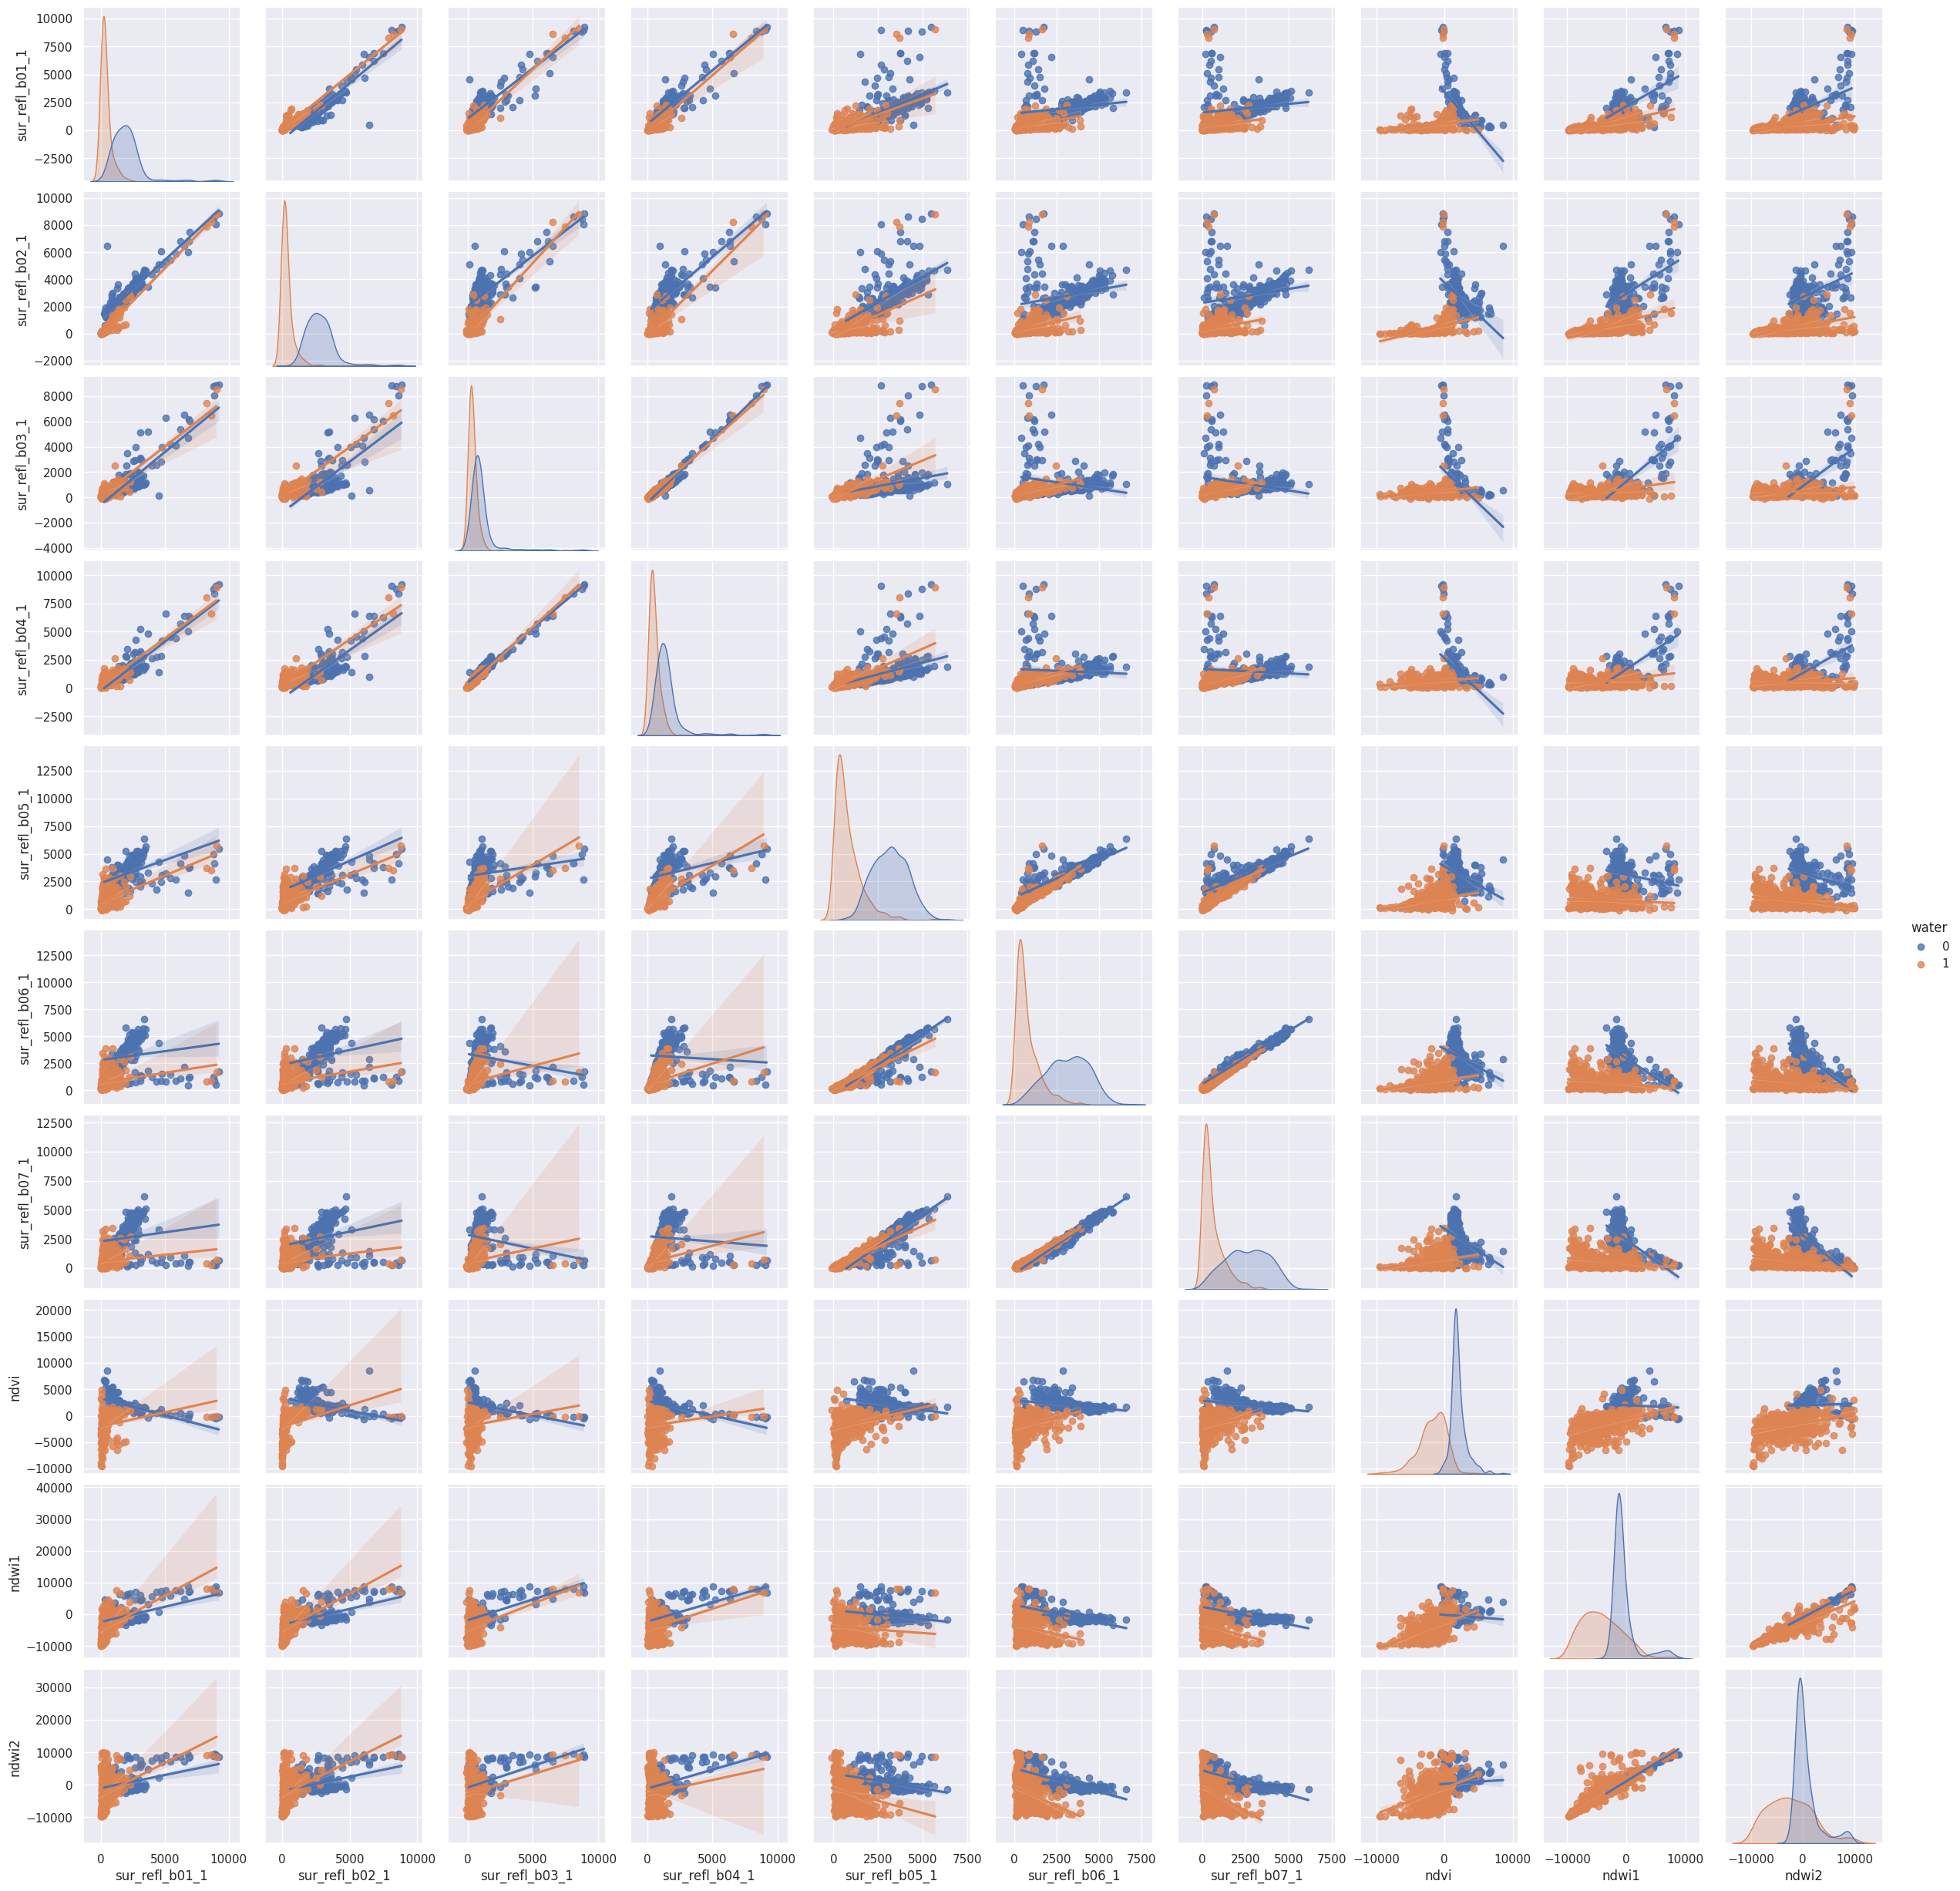

In [25]:
sns.set()
sns.pairplot(df_pandas, hue='water', kind='reg')
plt.savefig('output/modisWaterTrainingEDA_Correlation_WaterHighlight.png')

### 5.2 Distribution for each channel

Another good practice is to understand the distribution of values for each column feature. This will show you where most of your data lives for each feature in the dataset, including the distribution of training labels.

array([[<Axes: title={'center': 'water'}>,
        <Axes: title={'center': 'sur_refl_b01_1'}>,
        <Axes: title={'center': 'sur_refl_b02_1'}>],
       [<Axes: title={'center': 'sur_refl_b03_1'}>,
        <Axes: title={'center': 'sur_refl_b04_1'}>,
        <Axes: title={'center': 'sur_refl_b05_1'}>],
       [<Axes: title={'center': 'sur_refl_b06_1'}>,
        <Axes: title={'center': 'sur_refl_b07_1'}>,
        <Axes: title={'center': 'ndvi'}>],
       [<Axes: title={'center': 'ndwi1'}>,
        <Axes: title={'center': 'ndwi2'}>, <Axes: >]], dtype=object)

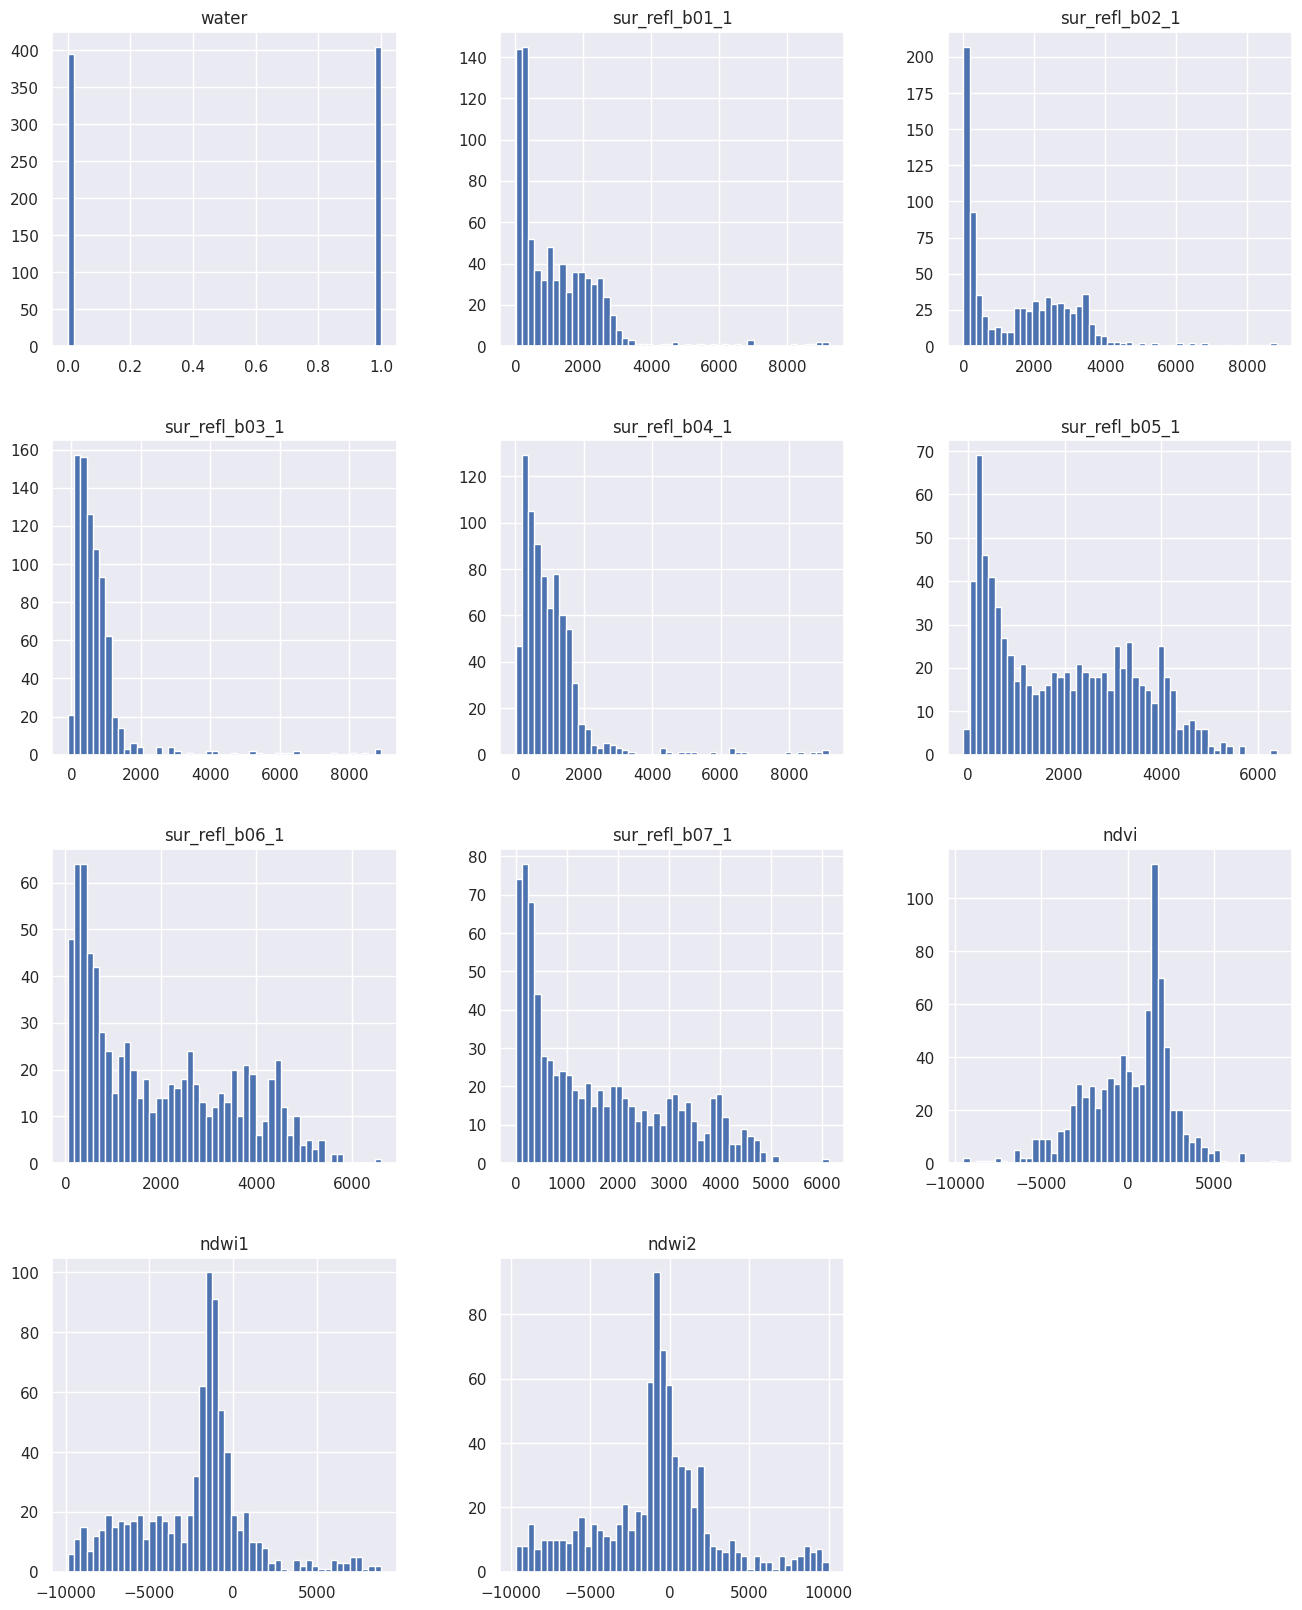

In [26]:
df_pandas.hist(figsize=(16, 20), bins=50)

### 5.3 Correlation calculations

Here we can do a more statistical approach to correlation using pandas corr() function.

In [27]:
# correlation with dataset - target value
corr = df_pandas.corr()['water']
corr.to_csv('output/correlation.csv')
corr

water             1.000000
sur_refl_b01_1   -0.604949
sur_refl_b02_1   -0.780173
sur_refl_b03_1   -0.315886
sur_refl_b04_1   -0.431506
sur_refl_b05_1   -0.813848
sur_refl_b06_1   -0.769546
sur_refl_b07_1   -0.720314
ndvi             -0.751600
ndwi1            -0.536501
ndwi2            -0.382001
Name: water, dtype: float64

In [28]:
# full correlation table
df_pandas.corr().style.background_gradient(cmap='viridis')

,water,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
water,1.000000,-0.604949,-0.780173,-0.315886,-0.431506,-0.813848,-0.769546,-0.720314,-0.751600,-0.536501,-0.382001
sur_refl_b01_1,-0.604949,1.000000,0.945684,0.857138,0.918364,0.736051,0.555226,0.520304,0.365613,0.644189,0.479509
sur_refl_b02_1,-0.780173,0.945684,1.000000,0.725588,0.814153,0.854383,0.699178,0.653082,0.574397,0.676687,0.499082
sur_refl_b03_1,-0.315886,0.857138,0.725588,1.000000,0.979398,0.447638,0.195292,0.152493,0.148278,0.540643,0.427898
sur_refl_b04_1,-0.431506,0.918364,0.814153,0.979398,1.000000,0.592604,0.365734,0.324536,0.224591,0.547416,0.407715
sur_refl_b05_1,-0.813848,0.736051,0.854383,0.447638,0.592604,1.000000,0.948514,0.919976,0.611504,0.362238,0.163515
sur_refl_b06_1,-0.769546,0.555226,0.699178,0.195292,0.365734,0.948514,1.000000,0.991028,0.571557,0.203993,0.023099
sur_refl_b07_1,-0.720314,0.520304,0.653082,0.152493,0.324536,0.919976,0.991028,1.000000,0.519074,0.156148,-0.038017
ndvi,-0.751600,0.365613,0.574397,0.148278,0.224591,0.611504,0.571557,0.519074,1.000000,0.588516,0.469716
ndwi1,-0.536501,0.644189,0.676687,0.540643,0.547416,0.362238,0.203993,0.156148,0.588516,1.000000,0.890413


## 5.4 Another Look at Distributions

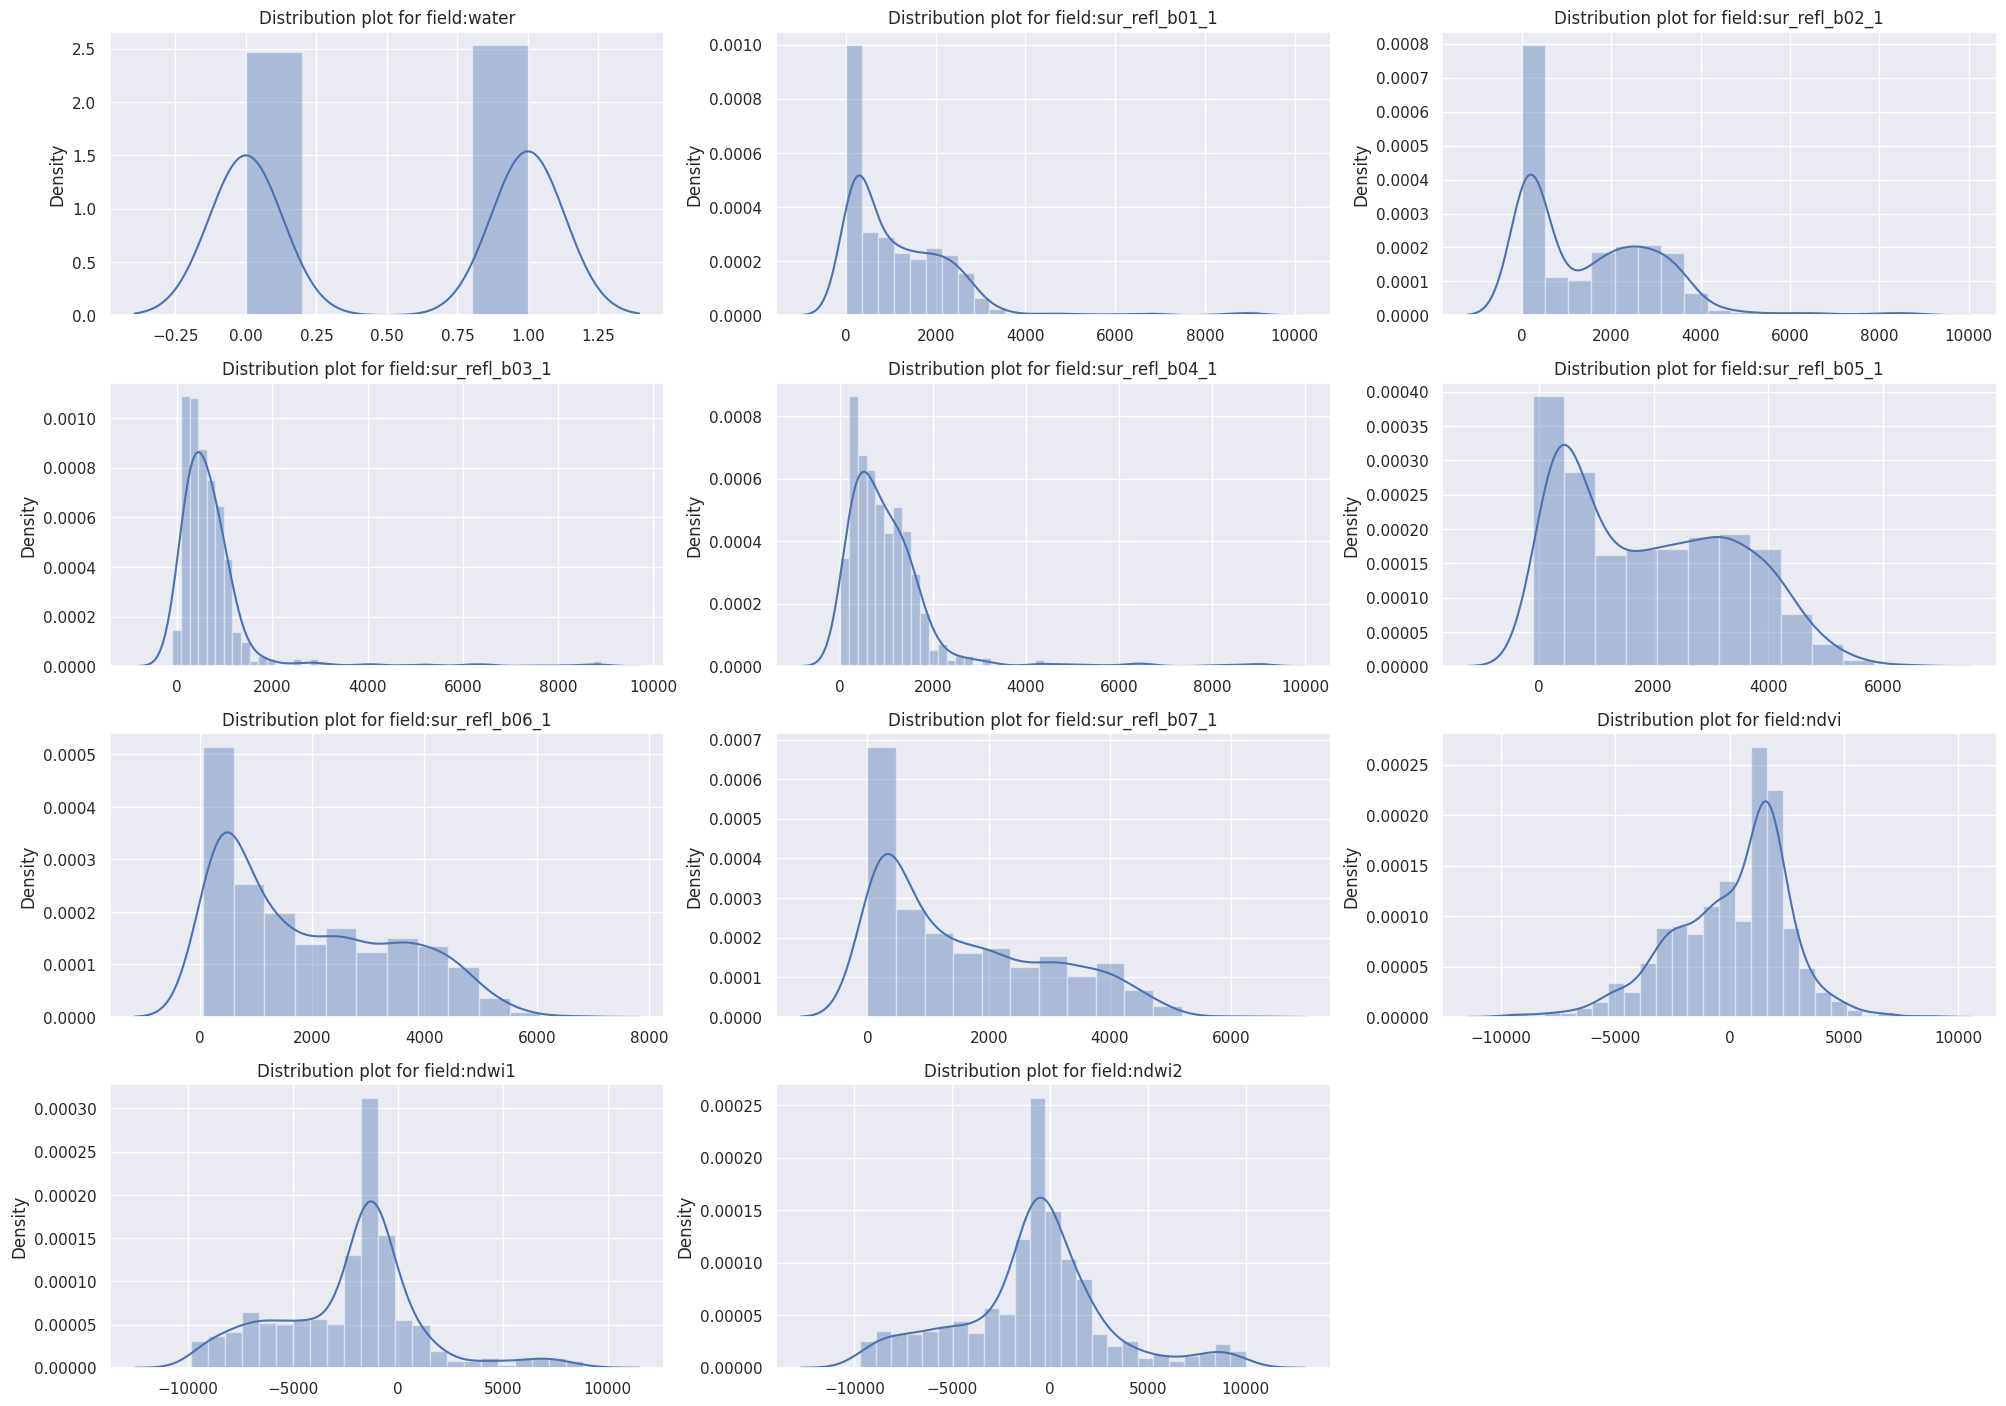

In [29]:
plt.figure(figsize=(20, 14))

for i, c in enumerate(df_pandas.select_dtypes(include='number').columns):
    plt.subplot(4,3,i+1)
    sns.distplot(df_pandas[c])
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig('output/output_dist_modis_water.png')

We can also target specifically the distribution of specific features when related to the corresponding label.

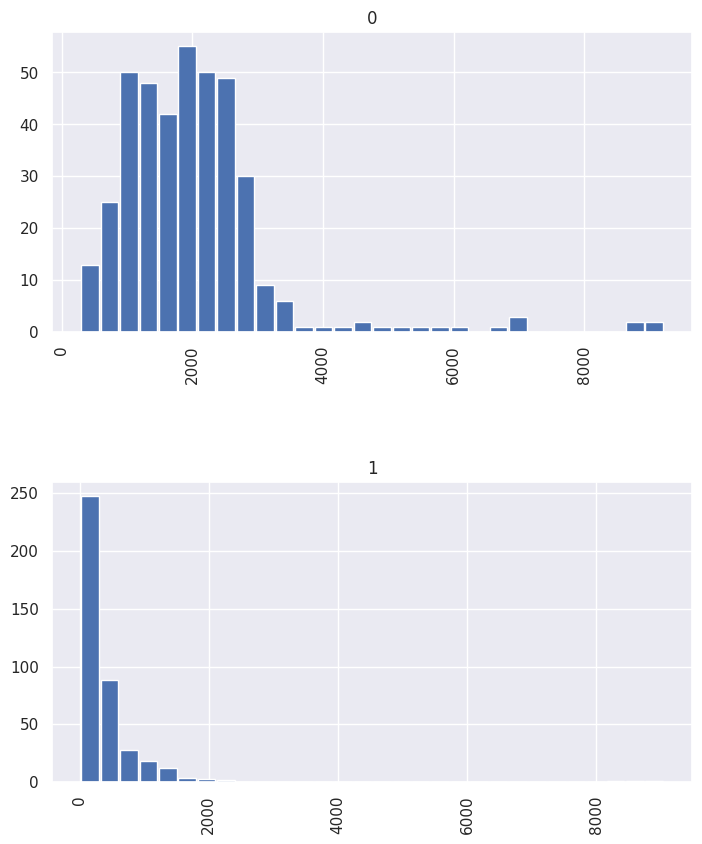

In [30]:
df_pandas.hist(column='sur_refl_b01_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
plt.savefig('output/b01_dist.png')

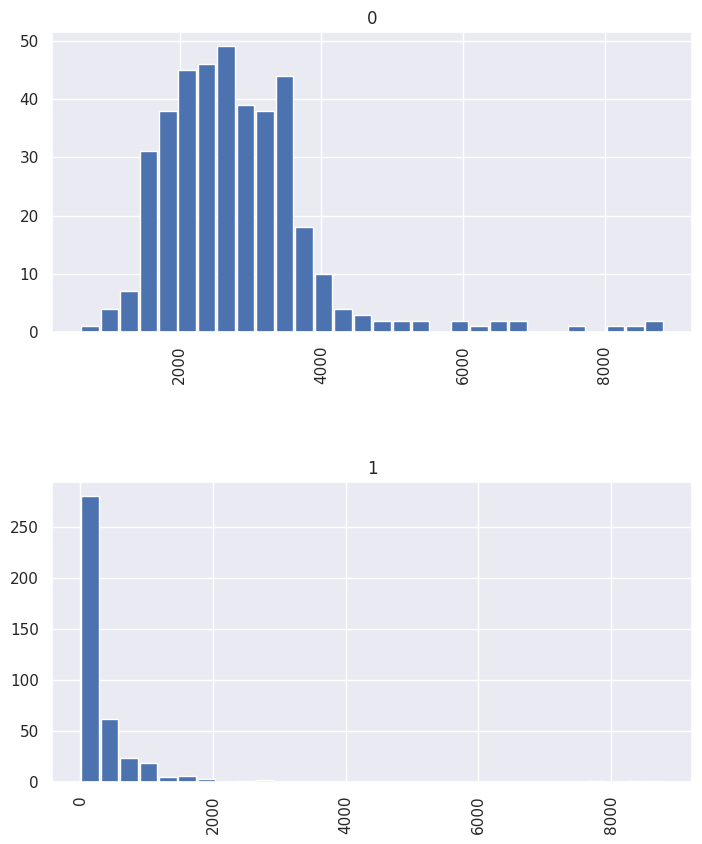

In [31]:
df_pandas.hist(column='sur_refl_b02_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
plt.savefig('output/b02_dist.png')

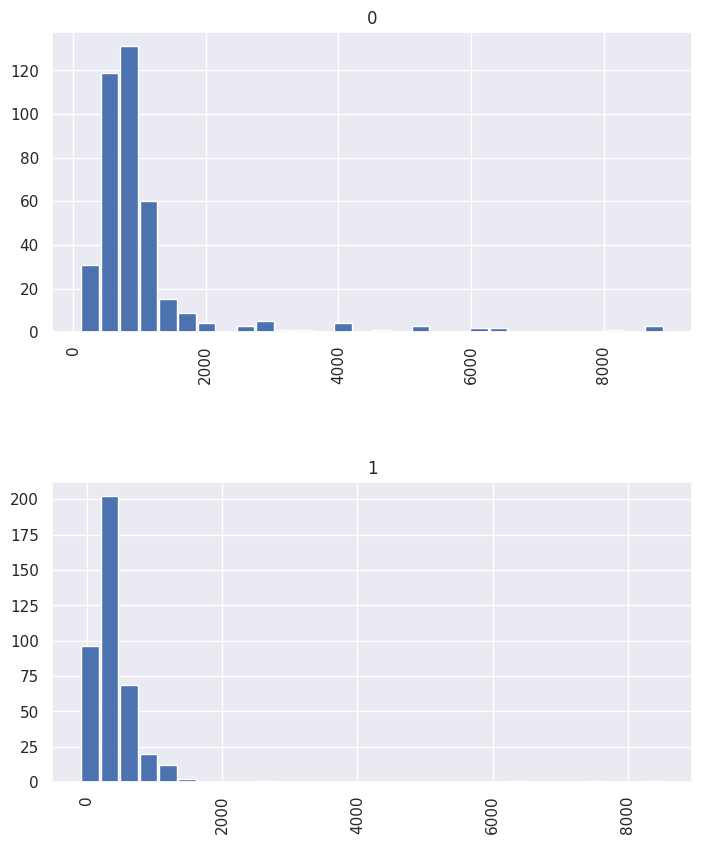

In [32]:
df_pandas.hist(column='sur_refl_b03_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
plt.savefig('output/b03_dist.png')

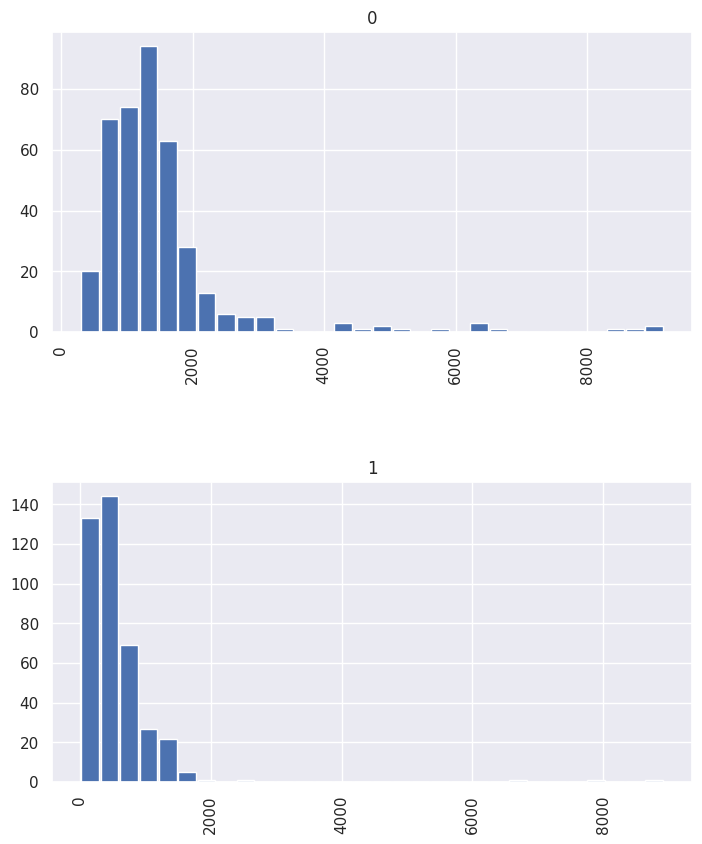

In [33]:
df_pandas.hist(column='sur_refl_b04_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
plt.savefig('output/b04_dist.png')

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

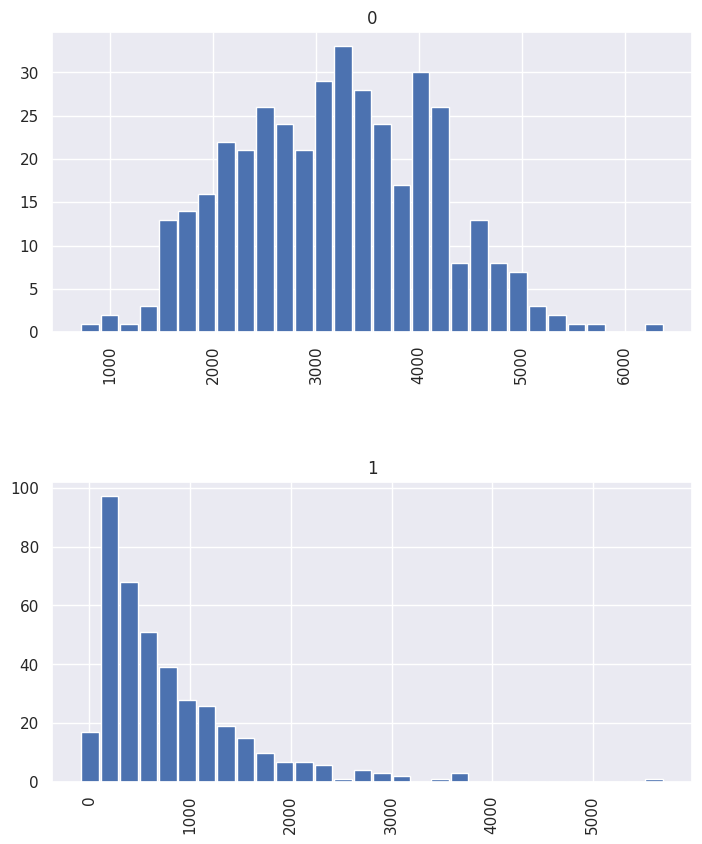

In [ ]:
df_pandas.hist(column='sur_refl_b05_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b05_dist.png'.format(TILE))

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

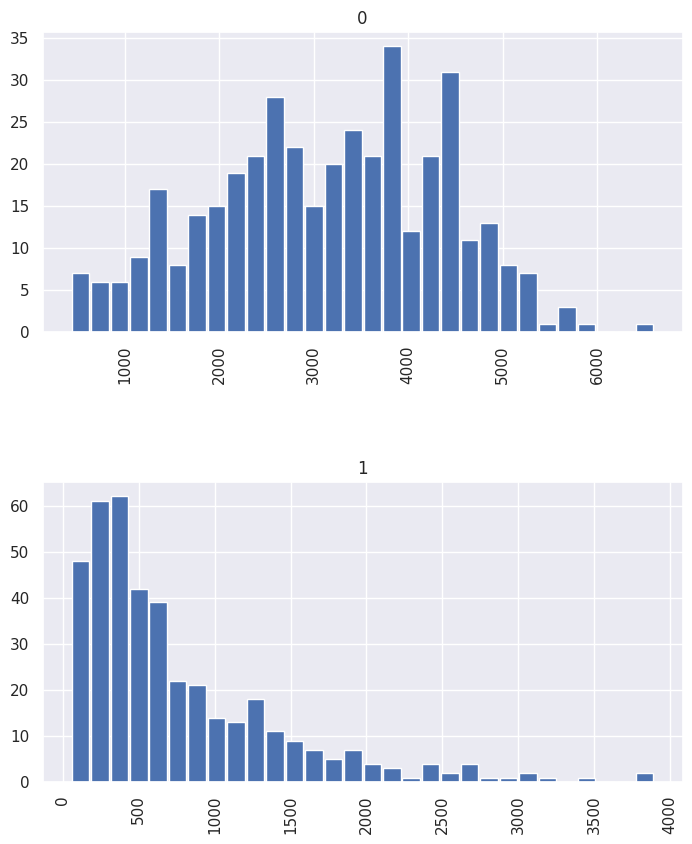

In [ ]:
df_pandas.hist(column='sur_refl_b06_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b06_dist.png'.format(TILE))

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

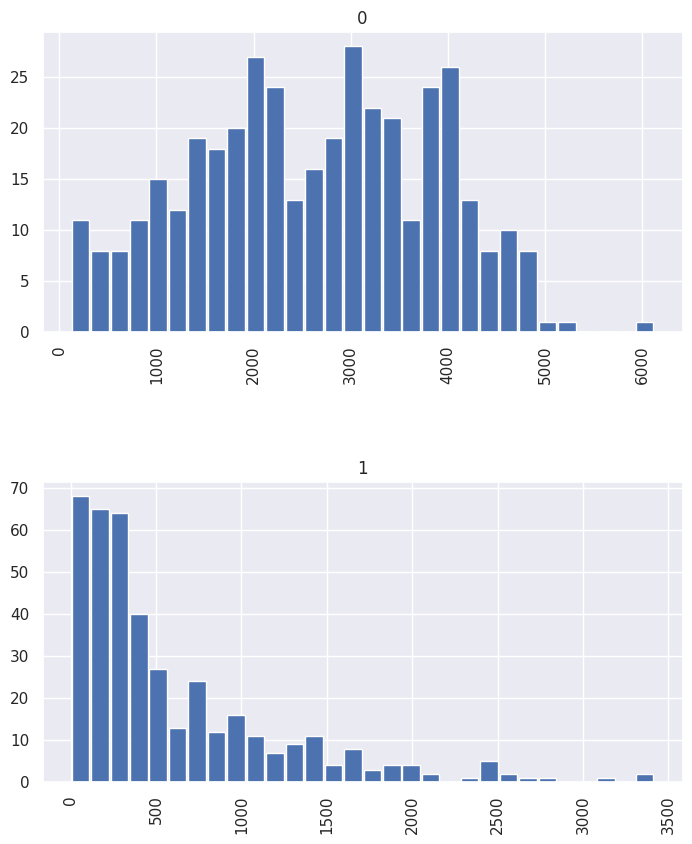

In [ ]:
df_pandas.hist(column='sur_refl_b07_1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=False)
#plt.savefig('output/{}_b07_dist.png'.format(TILE))

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

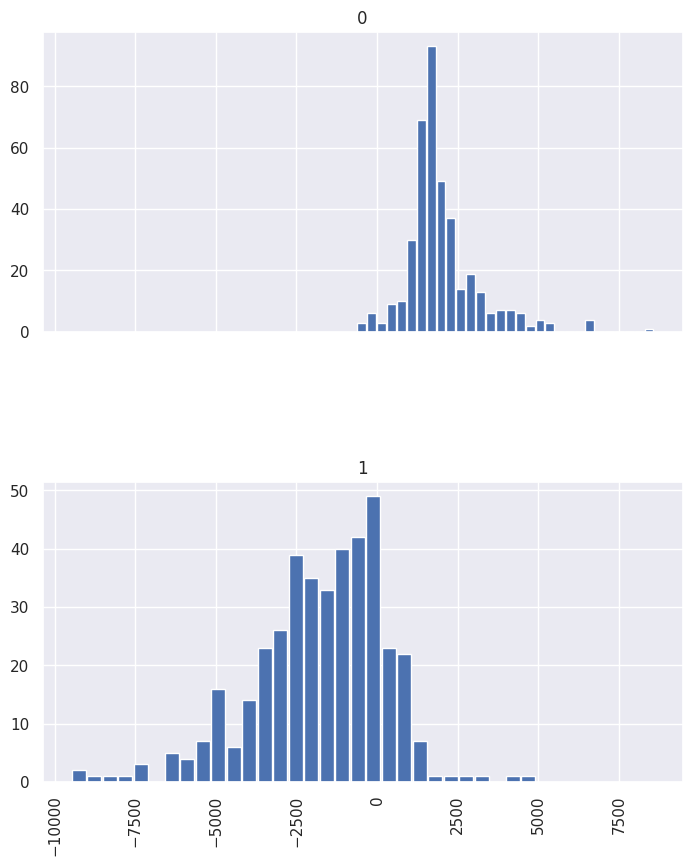

In [ ]:
df_pandas.hist(column='ndvi', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9, sharex=True)

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

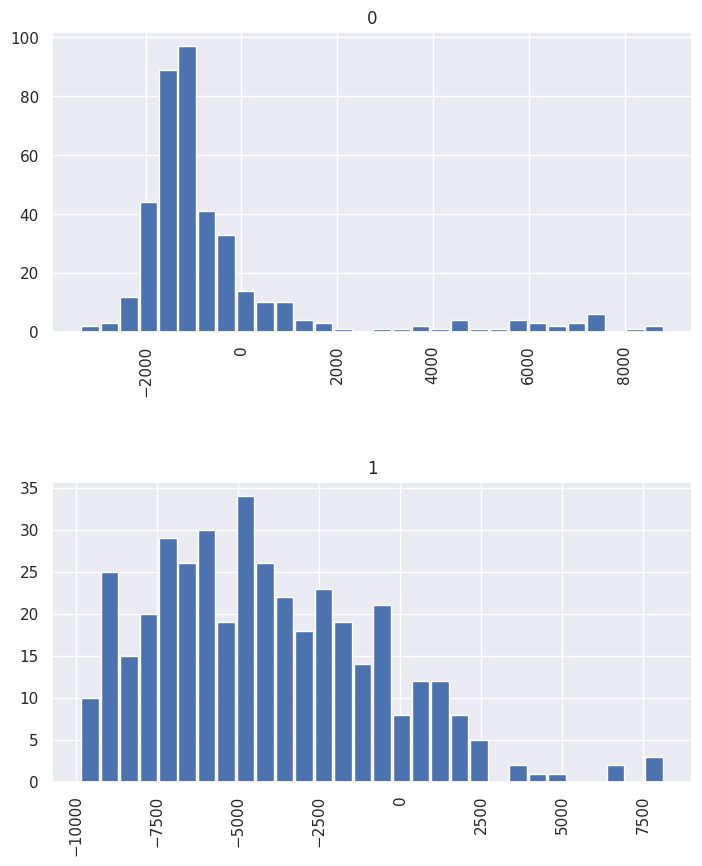

In [ ]:
df_pandas.hist(column='ndwi1', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9)

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

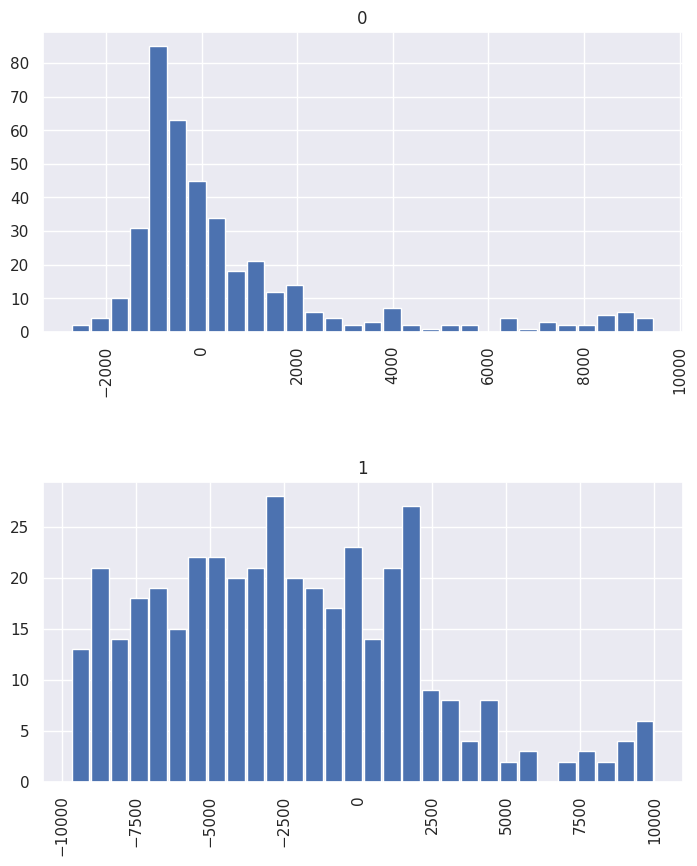

In [ ]:
df_pandas.hist(column='ndwi2', by='water', bins=30, grid=True, figsize=(8, 10), layout=(2, 1), zorder=2, rwidth=0.9)

### 5.5 Outlier Detection¶

Finding outliers is important to understand those corner cases where our models might not perform as expected, or where we might need additional training data from. There are several ways of finding outlier values, but we will concentrate on Tukey IQR for this example.

Tukey IQR rule says that the outliers are values more than 1.5 times the interquartile range from the quartiles — either below Q1 − 1.5 IQR, or above Q3 + 1.5IQR. Thus we can simply calculate outliers per column feature by taking the necessary percentiles.

In [34]:
def find_outliers_tukey(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    iqr = q3 - q1
    floor = q1 - 1.5*iqr
    ceiling = q3 + 1.5*iqr
    outlier_indices = list(x.index[(x<floor) | (x>ceiling)])
    outlier_values = list(x[outlier_indices])
    
    return outlier_indices,outlier_values

For example, outliers from ndwi2 are listed below:

In [35]:
tukey_indices,tukey_values = find_outliers_tukey(df_pandas['ndwi2'])
np.sort(tukey_values)

array([-9692, -9615, -9607, -9598, -9436, -9413, -9406, -9338, -9282,
       -9246, -9192, -9061, -9057, -9029, -9019, -8954, -8898, -8897,
       -8826, -8809, -8804, -8760, -8671, -8655, -8654, -8621, -8610,
       -8606, -8601, -8592, -8518, -8482, -8468, -8439,  6543,  6865,
        6965,  7083,  7089,  7219,  7328,  7602,  7650,  7714,  7848,
        7977,  8110,  8176,  8309,  8321,  8345,  8486,  8504,  8527,
        8569,  8664,  8669,  8679,  8682,  8918,  8990,  9076,  9093,
        9163,  9210,  9264,  9351,  9372,  9435,  9453,  9459,  9473,
        9848,  9858, 10000])

## 5.6 Feature Engineering, Creating New Features

There are cases were our features might not be enough for our model. We might have a small number of features, or a set of features that might not be representative enough. One general approach to solve this is to use feature engineering techniques to increase and/or improve our dataset representativeness.

For our water classification example, we do not need any feature engineering techniques, since we are able to perform accurate detections by simply calculating several indices and using the original optical bands.

However, this might be necessary in other problems where your data by itself might not provide enough representativeness.


In [39]:
def add_interactions(df):
    combos = list(combinations(list(df.columns),2))
    colnames = list(df.columns) + ['_'.join(x) for  x in combos]
    
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis= 1)
    
    return df

In this function we simply produce combinataions of each band that increases out feature space from 10 to 65. For an algorithm like a random forest where decisions are being made, this could provide a substantial improvement. Algorithms like convolutional neural networks might not need these since they can extract patterns directly out of the data.

In [40]:
df_pandas_expanded = add_interactions(df_pandas)
df_pandas_expanded.head()

,water,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,...,sur_refl_b06_1_sur_refl_b07_1,sur_refl_b06_1_ndvi,sur_refl_b06_1_ndwi1,sur_refl_b06_1_ndwi2,sur_refl_b07_1_ndvi,sur_refl_b07_1_ndwi1,sur_refl_b07_1_ndwi2,ndvi_ndwi1,ndvi_ndwi2,ndwi1_ndwi2
0,0.0,2031.0,3113.0,776.0,1200.0,3626.0,3480.0,2957.0,2103.0,-556.0,...,10290360.0,7318440.0,-1934880.0,894360.0,6218571.0,-1644092.0,759949.0,-1169268.0,540471.0,-142892.0
1,1.0,410.0,494.0,183.0,319.0,295.0,329.0,307.0,929.0,2004.0,...,101003.0,305641.0,659316.0,767886.0,285203.0,615228.0,716538.0,1861716.0,2168286.0,4677336.0
2,0.0,1609.0,2615.0,797.0,1000.0,2143.0,1708.0,1107.0,2381.0,2098.0,...,1890756.0,4066748.0,3583384.0,6919108.0,2635767.0,2322486.0,4484457.0,4995338.0,9645431.0,8498998.0
3,0.0,2593.0,3315.0,1250.0,1944.0,3923.0,4194.0,3909.0,1222.0,-1170.0,...,16394346.0,5125068.0,-4906980.0,-3447468.0,4776798.0,-4573530.0,-3213198.0,-1429740.0,-1004484.0,961740.0
4,0.0,2485.0,3365.0,905.0,1527.0,4520.0,4646.0,4137.0,1504.0,-1599.0,...,19220502.0,6987584.0,-7428954.0,-4780734.0,6222048.0,-6615063.0,-4256973.0,-2404896.0,-1547616.0,1645371.0


## 5.7 Dimesionality reduction using PCA

PCA is a tecnique that transforms a dataset of many features into pricipal components that summarize the variance that underlies the data. This can also be used to extract the principal components from each feature so they can be used in training.

In [42]:
pca = PCA(n_components=66)
X_pca = pd.DataFrame(pca.fit_transform(df_pandas_expanded))
X_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,-4.310427e+06,-2.158824e+07,8.401862e+06,7.146952e+06,4.377849e+06,1.224151e+06,5.625093e+05,9.313997e+05,-3.226322e+05,-1.724935e+06,...,2.074263,0.358994,-6.713978,0.917685,-1.567924,4.045103,0.135511,-0.108983,0.048881,-0.026456
1,-5.516881e+06,-2.940101e+06,-1.893098e+07,-2.290140e+06,4.510123e+05,4.672985e+05,-1.423265e+06,-2.067000e+06,1.257403e+06,2.070249e+05,...,-21.964011,-70.851753,46.722451,-3.846638,4.287904,8.307211,-0.052840,0.014334,-0.041414,-0.035211
2,1.032742e+07,-5.899496e+06,-1.446940e+07,1.282948e+07,9.420556e+06,1.695662e+06,4.634959e+05,-2.489900e+06,-3.778351e+06,7.057828e+05,...,-22.950894,-14.693588,-29.057870,-16.614984,-0.499390,-4.978857,-0.025569,-0.136995,0.010587,-0.016586
3,-6.167092e+06,-2.380347e+07,2.413577e+07,3.848482e+06,-3.642830e+06,1.996062e+06,-2.668080e+06,-1.161285e+06,-5.238799e+05,5.416549e+05,...,6.003388,12.370099,5.071167,0.776214,3.311614,6.295800,0.244635,0.132292,0.099219,-0.021385
4,-9.299378e+06,-2.497557e+07,3.096599e+07,3.584711e+06,-1.258757e+06,2.176176e+06,7.373333e+05,-5.441353e+05,2.067818e+06,2.181068e+05,...,25.504095,12.020508,4.124412,7.710674,0.761796,0.072756,-0.026081,0.399976,-0.060216,-0.033019


## Closing Thoughts

We have:
- Downloaded a MODIS based dataset for training, which we will use in the next portion of this training
- Performed EDA on the provided dataset and understand some of the characteristics of the given dataset
- Introduced several feature engineering techniques for dealing with no-data and to increase training data representativeness
- Provided additional tools to deal with the data and drive physical conclusions before going into training our machine learning model